In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import re
from pathlib import Path

from src.models import train_adult_income_baselines, train_german_credit_baselines
from src.data_loading import load_adult_income_dataset, load_german_credit_dataset
from src.fairness import calibration_within_groups

# Ensuring the output directory exists before writing any result tables or saving plots
# If results/ is missing, it will be created; if it already exists, nothing happens
RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def safe_filename(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"[\s]+", "_", s)
    return s[:120]

def unique_path(base_path: Path) -> Path:
    # Avoiding overwriting: if file exists, add _2, _3, ...
    if not base_path.exists():
        return base_path
    stem = base_path.stem
    suffix = base_path.suffix
    i = 2
    while True:
        candidate = base_path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def save_plot(title: str, filename: str | None = None, dpi: int = 200):
    """
    Saving the current matplotlib figure to results/plots as PNG.
    """
    if filename is None:
        filename = safe_filename(title) or "plot"
        filename = filename + ".png"

    path = unique_path(PLOTS_DIR / filename)

    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    # marking current figure as already saved (prevents double-save if called twice)
    fig = plt.gcf()
    setattr(fig, "_autosave_done", True)

    print("Saved plot:", path.as_posix())


# auto save feature when plt.show() is called
_ORIGINAL_SHOW = plt.show  # keeping reference so it can be restored if needed
_PLOT_COUNTER = 0

def get_current_plot_title() -> str:
    fig = plt.gcf()

    # Trying suptitle first
    st = getattr(fig, "_suptitle", None)
    if st is not None and st.get_text().strip():
        return st.get_text().strip()

    # Fallback to first axes title
    axes = fig.get_axes()
    if axes and axes[0].get_title().strip():
        return axes[0].get_title().strip()

    return ""

def autosave_current_figure_if_needed():
    global _PLOT_COUNTER
    fig = plt.gcf()

    # If this figure was already saved, skip (prevents duplicates)
    if getattr(fig, "_autosave_done", False):
        return

    title = get_current_plot_title()
    if not title:
        _PLOT_COUNTER += 1
        title = f"plot_{_PLOT_COUNTER:03d}"

    save_plot(title)

def show(*args, **kwargs):
    # Saving before showing
    try:
        autosave_current_figure_if_needed()
    except Exception as e:
        print("WARNING: autosave failed:", e)

    return _ORIGINAL_SHOW(*args, **kwargs)

# Monkey-patch matplotlib show
plt.show = show
print("Autosave enabled: every plt.show() will also save a PNG to results/plots/")


Autosave enabled: every plt.show() will also save a PNG to results/plots/


In [3]:
# Training baseline (unmitigated) models for both datasets
# Retraining(in every notebook), so this can run independently without relying on previous notebooks
adult_models = train_adult_income_baselines()
german_models = train_german_credit_baselines()

# Loading the TEST splits which will be used to evaluate calibration within groups
X_test_a, y_test_a, A_test_a, df_test_a = load_adult_income_dataset("test")
X_test_g, y_test_g, A_test_g, df_test_g = load_german_credit_dataset("test")

[Adult income] dummy: val accuracy = 0.751
[Adult income] logreg: val accuracy = 0.847
[Adult income] tree: val accuracy = 0.814
[Adult income] rf: val accuracy = 0.851
[Adult income] gb: val accuracy = 0.859
[German credit] dummy: val accuracy = 0.700
[German credit] logreg: val accuracy = 0.795
[German credit] tree: val accuracy = 0.720
[German credit] rf: val accuracy = 0.765
[German credit] gb: val accuracy = 0.760


In [4]:
# Computing calibration within groups for Adult Income baseline models using "sex" as the grouping attribute
# Using Brier Score: lower Brier score => better calibration (probabilities closer to true outcomes)
adult_calib_sex = calibration_within_groups(adult_models,X_test_a,y_test_a,A_test=df_test_a["sex"],dataset_name="adult_income")
# Displaying the calibration summary table
display(adult_calib_sex)
# Saving results
adult_calib_sex.to_csv("results/adult_baseline_calibration_sex.csv", index=False)
print("Saved: results/adult_baseline_calibration_sex.csv")


,dataset,model,brier_overall,brier_min_group,brier_max_group,brier_diff
0,adult_income,dummy,0.245684,0.113373,0.309747,0.196374
1,adult_income,logreg,0.104755,0.056373,0.128180,0.071807
2,adult_income,tree,0.193293,0.112355,0.232483,0.120128
3,adult_income,rf,0.106779,0.056900,0.130929,0.074029
4,adult_income,gb,0.094704,0.050485,0.116114,0.065628


Saved: results/adult_baseline_calibration_sex.csv


In [5]:
# computing calibration within groups using "race" as the grouping attribute for comparison
# using Brier score per group and the max-min gap
try:
    adult_calib_race = calibration_within_groups(adult_models, X_test_a,y_test_a,A_test=df_test_a["race"],dataset_name="adult_income")
    display(adult_calib_race)
    adult_calib_race.to_csv("results/adult_baseline_calibration_race.csv", index=False)
    print("Saved: results/adult_baseline_calibration_race.csv")
except Exception as e:
    print("Race calibration skipped or failed:", e)


,dataset,model,brier_overall,brier_min_group,brier_max_group,brier_diff
0,adult_income,dummy,0.245684,0.119064,0.296569,0.177504
1,adult_income,logreg,0.104755,0.061567,0.119642,0.058075
2,adult_income,tree,0.193293,0.114094,0.242647,0.128553
3,adult_income,rf,0.106779,0.057152,0.118299,0.061147
4,adult_income,gb,0.094704,0.052491,0.119491,0.067000


Saved: results/adult_baseline_calibration_race.csv


In [6]:
# Computing calibration within groups for German Credit baseline models using "sex" as the grouping attribute
# Using Brier Score: lower Brier score => better calibration
german_calib = calibration_within_groups(german_models,X_test_g,y_test_g,A_test=df_test_g["sex"],dataset_name="german_credit")
display(german_calib)
german_calib.to_csv("results/german_baseline_calibration_sex.csv", index=False)
print("Saved: results/german_baseline_calibration_sex.csv")

,dataset,model,brier_overall,brier_min_group,brier_max_group,brier_diff
0,german_credit,dummy,0.300000,0.285714,0.333333,0.047619
1,german_credit,logreg,0.188140,0.173611,0.222042,0.048431
2,german_credit,tree,0.325000,0.292857,0.400000,0.107143
3,german_credit,rf,0.166142,0.151534,0.200226,0.048692
4,german_credit,gb,0.175115,0.154183,0.223955,0.069772


Saved: results/german_baseline_calibration_sex.csv


Saved plot: results/plots/adult_income_sex_calibration_disparity_brier_diff.png


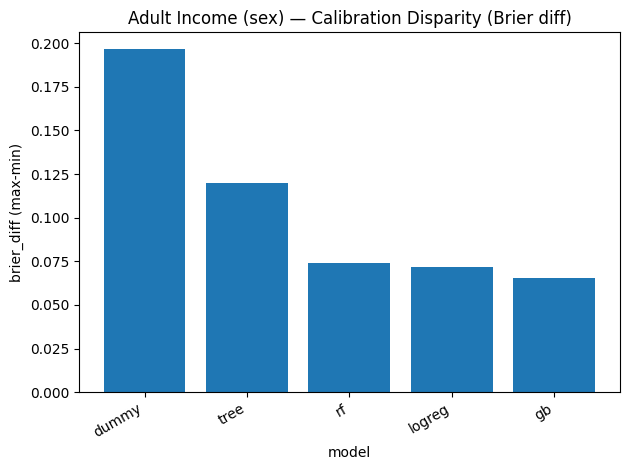

In [7]:
# Sorting models by calibration disparity so the largest cross-group calibration gap appears first
# brier_diff = (worst group Brier score) - (best group Brier score)
# Lower values mean more similar calibration across groups (more equitable calibration)
df = adult_calib_sex.sort_values("brier_diff", ascending=False)

# Plotting the calibration disparity as a bar chart
plt.figure()
plt.bar(df["model"], df["brier_diff"])
plt.title("Adult Income (sex) — Calibration Disparity (Brier diff)")
plt.xlabel("model")
plt.ylabel("brier_diff (max-min)")
plt.xticks(rotation=30, ha="right")
plt.show()


Saved plot: results/plots/german_credit_calibration_disparity_brier_diff.png


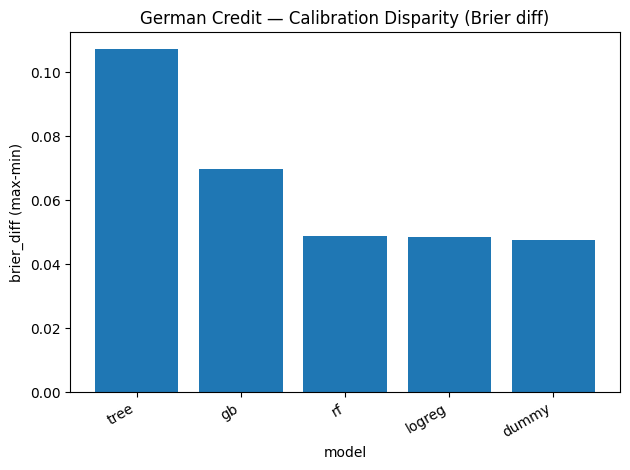

In [8]:
# Sorting German Credit models by calibration disparity so the largest cross-group calibration gap appears first
# brier_diff = (worst group Brier score) - (best group Brier score)
# Lower values indicate more similar calibration across groups (more equitable calibration)
df = german_calib.sort_values("brier_diff", ascending=False)

# Plotting the calibration disparity as a bar chart
plt.figure()
plt.bar(df["model"], df["brier_diff"])
plt.title("German Credit — Calibration Disparity (Brier diff)")
plt.xlabel("model")
plt.ylabel("brier_diff (max-min)")
plt.xticks(rotation=30, ha="right")
plt.show()